In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='50-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
INPUT_PT_PATH = f"/workspace/datasets/profiles-v2/profiles-v2-pca-5d/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca-5d/profiles_v2_experiment_50-5d_20250803_0146


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca-5d/profiles_v2_experiment_50-5d_20250803_0146/density_plot.png


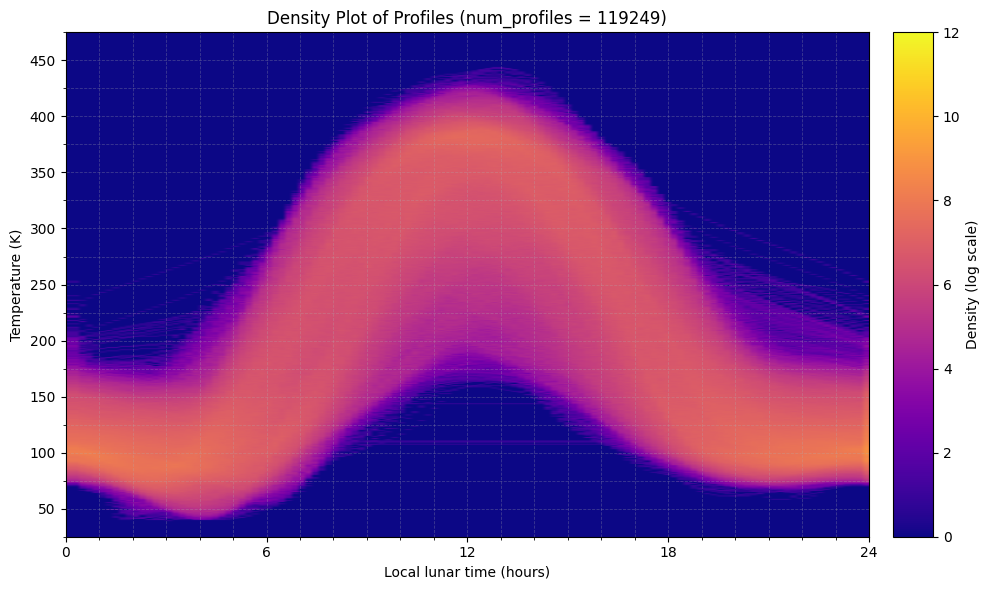

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.5726
STD: 97.7524
Min Temp: 40.0240
Max Temp: 443.4440
Datasets:
Training Data: 83474
Validation Data: 23849
Test Data: 11926


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 418/418 [00:13<00:00, 30.15it/s, best_loss=0.8873]


[Training] Epoch 1/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0031, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 120/120 [00:01<00:00, 97.90it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0002
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_50-5d_20250803_0146'


[Training] Epoch 2/100: 100%|██████████| 418/418 [00:14<00:00, 29.66it/s, best_loss=0.8871]


[Training] Epoch 2/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 120/120 [00:01<00:00, 100.25it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 3/100: 100%|██████████| 418/418 [00:14<00:00, 29.49it/s, best_loss=0.8818]


[Training] Epoch 3/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 120/120 [00:01<00:00, 100.89it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 4/100: 100%|██████████| 418/418 [00:14<00:00, 28.90it/s, best_loss=0.8596]


[Training] Epoch 4/100, L1 Loss: 0.8179, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 120/120 [00:01<00:00, 100.54it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 5/100: 100%|██████████| 418/418 [00:14<00:00, 29.57it/s, best_loss=0.8810]


[Training] Epoch 5/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 120/120 [00:01<00:00, 98.60it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 6/100: 100%|██████████| 418/418 [00:13<00:00, 30.10it/s, best_loss=0.8909]


[Training] Epoch 6/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 120/120 [00:01<00:00, 103.41it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 7/100: 100%|██████████| 418/418 [00:14<00:00, 29.55it/s, best_loss=0.8921]


[Training] Epoch 7/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 120/120 [00:01<00:00, 101.29it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 8/100: 100%|██████████| 418/418 [00:14<00:00, 29.30it/s, best_loss=0.8767]


[Training] Epoch 8/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 120/120 [00:01<00:00, 95.14it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 9/100: 100%|██████████| 418/418 [00:14<00:00, 29.68it/s, best_loss=0.8762]


[Training] Epoch 9/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 120/120 [00:01<00:00, 102.73it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 10/100: 100%|██████████| 418/418 [00:14<00:00, 29.58it/s, best_loss=0.8604]


[Training] Epoch 10/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 120/120 [00:01<00:00, 97.08it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 11/100: 100%|██████████| 418/418 [00:14<00:00, 29.44it/s, best_loss=0.8854]


[Training] Epoch 11/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 120/120 [00:01<00:00, 93.39it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 12/100: 100%|██████████| 418/418 [00:14<00:00, 29.09it/s, best_loss=0.8998]


[Training] Epoch 12/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 120/120 [00:01<00:00, 99.36it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 13/100: 100%|██████████| 418/418 [00:14<00:00, 29.26it/s, best_loss=0.8947]


[Training] Epoch 13/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 120/120 [00:01<00:00, 100.36it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 14/100: 100%|██████████| 418/418 [00:14<00:00, 29.19it/s, best_loss=0.8987]


[Training] Epoch 14/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 120/120 [00:01<00:00, 96.99it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 15/100: 100%|██████████| 418/418 [00:14<00:00, 29.30it/s, best_loss=0.8890]


[Training] Epoch 15/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 120/120 [00:01<00:00, 99.24it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 16/100: 100%|██████████| 418/418 [00:14<00:00, 29.35it/s, best_loss=0.8820]


[Training] Epoch 16/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 120/120 [00:01<00:00, 92.89it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 17/100: 100%|██████████| 418/418 [00:13<00:00, 30.41it/s, best_loss=0.8615]


[Training] Epoch 17/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 120/120 [00:01<00:00, 96.18it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 18/100: 100%|██████████| 418/418 [00:14<00:00, 29.42it/s, best_loss=0.8876]


[Training] Epoch 18/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 120/120 [00:01<00:00, 98.62it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 19/100: 100%|██████████| 418/418 [00:14<00:00, 29.53it/s, best_loss=0.8510]


[Training] Epoch 19/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 120/120 [00:01<00:00, 99.29it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 20/100: 100%|██████████| 418/418 [00:14<00:00, 29.79it/s, best_loss=0.8982]


[Training] Epoch 20/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 120/120 [00:01<00:00, 101.17it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 21/100: 100%|██████████| 418/418 [00:14<00:00, 28.65it/s, best_loss=0.8571]


[Training] Epoch 21/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 120/120 [00:01<00:00, 98.15it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 22/100: 100%|██████████| 418/418 [00:13<00:00, 29.87it/s, best_loss=0.8734]


[Training] Epoch 22/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 120/120 [00:01<00:00, 97.93it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 23/100: 100%|██████████| 418/418 [00:14<00:00, 29.54it/s, best_loss=0.8724]


[Training] Epoch 23/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 120/120 [00:01<00:00, 100.83it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 24/100: 100%|██████████| 418/418 [00:14<00:00, 29.25it/s, best_loss=0.8706]


[Training] Epoch 24/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 120/120 [00:01<00:00, 97.51it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 25/100: 100%|██████████| 418/418 [00:14<00:00, 29.81it/s, best_loss=0.8856]


[Training] Epoch 25/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 120/120 [00:01<00:00, 100.95it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 26/100: 100%|██████████| 418/418 [00:13<00:00, 30.07it/s, best_loss=0.8711]


[Training] Epoch 26/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 120/120 [00:01<00:00, 98.01it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 27/100: 100%|██████████| 418/418 [00:13<00:00, 29.92it/s, best_loss=0.8585]


[Training] Epoch 27/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 120/120 [00:01<00:00, 103.28it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 28/100: 100%|██████████| 418/418 [00:14<00:00, 28.88it/s, best_loss=0.8672]


[Training] Epoch 28/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 120/120 [00:01<00:00, 97.88it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 29/100: 100%|██████████| 418/418 [00:14<00:00, 29.45it/s, best_loss=0.8897]


[Training] Epoch 29/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 120/120 [00:01<00:00, 100.29it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 30/100: 100%|██████████| 418/418 [00:14<00:00, 29.38it/s, best_loss=0.8840]


[Training] Epoch 30/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 120/120 [00:01<00:00, 100.38it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 31/100: 100%|██████████| 418/418 [00:14<00:00, 28.90it/s, best_loss=0.8755]


[Training] Epoch 31/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 120/120 [00:01<00:00, 98.76it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 32/100: 100%|██████████| 418/418 [00:14<00:00, 29.51it/s, best_loss=0.8927]


[Training] Epoch 32/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 120/120 [00:01<00:00, 101.40it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 33/100: 100%|██████████| 418/418 [00:14<00:00, 29.85it/s, best_loss=0.8841]


[Training] Epoch 33/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 120/120 [00:01<00:00, 90.29it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 34/100: 100%|██████████| 418/418 [00:14<00:00, 29.71it/s, best_loss=0.8937]


[Training] Epoch 34/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 120/120 [00:01<00:00, 100.43it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 35/100: 100%|██████████| 418/418 [00:14<00:00, 29.82it/s, best_loss=0.8869]


[Training] Epoch 35/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 120/120 [00:01<00:00, 99.32it/s] 


[Validation] Epoch 35/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 36/100: 100%|██████████| 418/418 [00:14<00:00, 29.29it/s, best_loss=0.8640]


[Training] Epoch 36/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 120/120 [00:01<00:00, 102.23it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 37/100: 100%|██████████| 418/418 [00:14<00:00, 29.65it/s, best_loss=0.8598]


[Training] Epoch 37/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 120/120 [00:01<00:00, 99.23it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 38/100: 100%|██████████| 418/418 [00:14<00:00, 29.37it/s, best_loss=0.9002]


[Training] Epoch 38/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 120/120 [00:01<00:00, 101.35it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 39/100: 100%|██████████| 418/418 [00:14<00:00, 29.81it/s, best_loss=0.8891]


[Training] Epoch 39/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 120/120 [00:01<00:00, 101.50it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 40/100: 100%|██████████| 418/418 [00:14<00:00, 29.23it/s, best_loss=0.8570]


[Training] Epoch 40/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 120/120 [00:01<00:00, 101.12it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 41/100: 100%|██████████| 418/418 [00:14<00:00, 29.57it/s, best_loss=0.8536]


[Training] Epoch 41/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 120/120 [00:01<00:00, 97.28it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 42/100: 100%|██████████| 418/418 [00:13<00:00, 30.14it/s, best_loss=0.8446]


[Training] Epoch 42/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 120/120 [00:01<00:00, 103.75it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 43/100: 100%|██████████| 418/418 [00:13<00:00, 30.25it/s, best_loss=0.8943]


[Training] Epoch 43/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 120/120 [00:01<00:00, 100.35it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 44/100: 100%|██████████| 418/418 [00:13<00:00, 30.18it/s, best_loss=0.8823]


[Training] Epoch 44/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 120/120 [00:01<00:00, 101.96it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 45/100: 100%|██████████| 418/418 [00:13<00:00, 30.20it/s, best_loss=0.8749]


[Training] Epoch 45/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 120/120 [00:01<00:00, 94.02it/s] 


[Validation] Epoch 45/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 46/100: 100%|██████████| 418/418 [00:14<00:00, 29.62it/s, best_loss=0.8659]


[Training] Epoch 46/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 120/120 [00:01<00:00, 101.38it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 47/100: 100%|██████████| 418/418 [00:13<00:00, 29.88it/s, best_loss=0.8680]


[Training] Epoch 47/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 120/120 [00:01<00:00, 105.27it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 48/100: 100%|██████████| 418/418 [00:14<00:00, 29.47it/s, best_loss=0.8648]


[Training] Epoch 48/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 120/120 [00:01<00:00, 100.73it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 49/100: 100%|██████████| 418/418 [00:14<00:00, 29.41it/s, best_loss=0.8945]


[Training] Epoch 49/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 120/120 [00:01<00:00, 96.93it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 50/100: 100%|██████████| 418/418 [00:14<00:00, 29.14it/s, best_loss=0.8531]


[Training] Epoch 50/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 120/120 [00:01<00:00, 91.33it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 51/100: 100%|██████████| 418/418 [00:14<00:00, 29.85it/s, best_loss=0.8919]


[Training] Epoch 51/100, L1 Loss: 0.8180, L2 Loss: 1.0003, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 120/120 [00:01<00:00, 102.20it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 52/100: 100%|██████████| 418/418 [00:13<00:00, 30.00it/s, best_loss=0.8844]


[Training] Epoch 52/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 120/120 [00:01<00:00, 100.40it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 53/100: 100%|██████████| 418/418 [00:14<00:00, 29.16it/s, best_loss=0.8775]


[Training] Epoch 53/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 120/120 [00:01<00:00, 101.24it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 54/100: 100%|██████████| 418/418 [00:14<00:00, 29.27it/s, best_loss=0.8877]


[Training] Epoch 54/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 120/120 [00:01<00:00, 91.39it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 55/100: 100%|██████████| 418/418 [00:14<00:00, 29.49it/s, best_loss=0.8931]


[Training] Epoch 55/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 120/120 [00:01<00:00, 98.38it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 56/100: 100%|██████████| 418/418 [00:14<00:00, 29.22it/s, best_loss=0.8832]


[Training] Epoch 56/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 120/120 [00:01<00:00, 94.92it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 57/100: 100%|██████████| 418/418 [00:13<00:00, 30.01it/s, best_loss=0.8725]


[Training] Epoch 57/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 120/120 [00:01<00:00, 101.20it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 58/100: 100%|██████████| 418/418 [00:13<00:00, 30.11it/s, best_loss=0.8896]


[Training] Epoch 58/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 120/120 [00:01<00:00, 98.36it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 59/100: 100%|██████████| 418/418 [00:13<00:00, 30.04it/s, best_loss=0.8835]


[Training] Epoch 59/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 120/120 [00:01<00:00, 98.63it/s] 


[Validation] Epoch 59/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 60/100: 100%|██████████| 418/418 [00:14<00:00, 28.81it/s, best_loss=0.8593]


[Training] Epoch 60/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 120/120 [00:01<00:00, 98.02it/s] 


[Validation] Epoch 60/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 61/100: 100%|██████████| 418/418 [00:14<00:00, 29.69it/s, best_loss=0.8921]


[Training] Epoch 61/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 120/120 [00:01<00:00, 102.00it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 62/100: 100%|██████████| 418/418 [00:14<00:00, 29.50it/s, best_loss=0.8753]


[Training] Epoch 62/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 120/120 [00:01<00:00, 93.50it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 63/100: 100%|██████████| 418/418 [00:13<00:00, 30.04it/s, best_loss=0.8826]


[Training] Epoch 63/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 120/120 [00:01<00:00, 105.46it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 64/100: 100%|██████████| 418/418 [00:14<00:00, 28.98it/s, best_loss=0.8699]


[Training] Epoch 64/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 120/120 [00:01<00:00, 96.80it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 65/100: 100%|██████████| 418/418 [00:14<00:00, 29.77it/s, best_loss=0.8883]


[Training] Epoch 65/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 120/120 [00:01<00:00, 99.82it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 66/100: 100%|██████████| 418/418 [00:13<00:00, 30.17it/s, best_loss=0.8916]


[Training] Epoch 66/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 120/120 [00:01<00:00, 102.66it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 67/100: 100%|██████████| 418/418 [00:14<00:00, 29.71it/s, best_loss=0.8856]


[Training] Epoch 67/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 120/120 [00:01<00:00, 98.33it/s] 


[Validation] Epoch 67/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 68/100: 100%|██████████| 418/418 [00:14<00:00, 29.67it/s, best_loss=0.8605]


[Training] Epoch 68/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 120/120 [00:01<00:00, 89.98it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 69/100: 100%|██████████| 418/418 [00:14<00:00, 29.48it/s, best_loss=0.8856]


[Training] Epoch 69/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 120/120 [00:01<00:00, 96.29it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 70/100: 100%|██████████| 418/418 [00:14<00:00, 29.08it/s, best_loss=0.8817]


[Training] Epoch 70/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 120/120 [00:01<00:00, 99.00it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 71/100: 100%|██████████| 418/418 [00:14<00:00, 29.36it/s, best_loss=0.8865]


[Training] Epoch 71/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 120/120 [00:01<00:00, 99.76it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 72/100: 100%|██████████| 418/418 [00:14<00:00, 28.95it/s, best_loss=0.8528]


[Training] Epoch 72/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 120/120 [00:01<00:00, 98.91it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 73/100: 100%|██████████| 418/418 [00:14<00:00, 29.49it/s, best_loss=0.8815]


[Training] Epoch 73/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 120/120 [00:01<00:00, 97.41it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 74/100: 100%|██████████| 418/418 [00:14<00:00, 29.23it/s, best_loss=0.8687]


[Training] Epoch 74/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 120/120 [00:01<00:00, 98.48it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 75/100: 100%|██████████| 418/418 [00:14<00:00, 29.73it/s, best_loss=0.9118]


[Training] Epoch 75/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 120/120 [00:01<00:00, 98.20it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 76/100: 100%|██████████| 418/418 [00:14<00:00, 29.69it/s, best_loss=0.8941]


[Training] Epoch 76/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 120/120 [00:01<00:00, 96.23it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 77/100: 100%|██████████| 418/418 [00:14<00:00, 28.75it/s, best_loss=0.8796]


[Training] Epoch 77/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 120/120 [00:01<00:00, 94.20it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 78/100: 100%|██████████| 418/418 [00:14<00:00, 28.87it/s, best_loss=0.8930]


[Training] Epoch 78/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 120/120 [00:01<00:00, 88.61it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 79/100: 100%|██████████| 418/418 [00:14<00:00, 29.23it/s, best_loss=0.8883]


[Training] Epoch 79/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 120/120 [00:01<00:00, 101.25it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 80/100: 100%|██████████| 418/418 [00:14<00:00, 29.15it/s, best_loss=0.8774]


[Training] Epoch 80/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 120/120 [00:01<00:00, 92.87it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 81/100: 100%|██████████| 418/418 [00:14<00:00, 29.21it/s, best_loss=0.8860]


[Training] Epoch 81/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 120/120 [00:01<00:00, 103.75it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 82/100: 100%|██████████| 418/418 [00:14<00:00, 29.58it/s, best_loss=0.8644]


[Training] Epoch 82/100, L1 Loss: 0.8180, L2 Loss: 1.0003, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 120/120 [00:01<00:00, 99.58it/s] 


[Validation] Epoch 82/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 83/100: 100%|██████████| 418/418 [00:13<00:00, 29.94it/s, best_loss=0.8741]


[Training] Epoch 83/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 120/120 [00:01<00:00, 94.49it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 84/100: 100%|██████████| 418/418 [00:14<00:00, 29.13it/s, best_loss=0.8685]


[Training] Epoch 84/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 120/120 [00:01<00:00, 87.34it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 85/100: 100%|██████████| 418/418 [00:14<00:00, 29.23it/s, best_loss=0.8677]


[Training] Epoch 85/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 120/120 [00:01<00:00, 96.06it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 86/100: 100%|██████████| 418/418 [00:14<00:00, 29.56it/s, best_loss=0.8521]


[Training] Epoch 86/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 120/120 [00:01<00:00, 102.33it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 87/100: 100%|██████████| 418/418 [00:14<00:00, 29.30it/s, best_loss=0.8887]


[Training] Epoch 87/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 120/120 [00:01<00:00, 103.72it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 88/100: 100%|██████████| 418/418 [00:14<00:00, 29.64it/s, best_loss=0.8713]


[Training] Epoch 88/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 120/120 [00:01<00:00, 101.75it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 89/100: 100%|██████████| 418/418 [00:14<00:00, 29.26it/s, best_loss=0.8796]


[Training] Epoch 89/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 120/120 [00:01<00:00, 104.35it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 90/100: 100%|██████████| 418/418 [00:14<00:00, 29.22it/s, best_loss=0.8730]


[Training] Epoch 90/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 120/120 [00:01<00:00, 98.08it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 91/100: 100%|██████████| 418/418 [00:14<00:00, 28.97it/s, best_loss=0.8930]


[Training] Epoch 91/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 120/120 [00:01<00:00, 100.13it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 92/100: 100%|██████████| 418/418 [00:14<00:00, 29.47it/s, best_loss=0.9013]


[Training] Epoch 92/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 120/120 [00:01<00:00, 100.00it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 93/100: 100%|██████████| 418/418 [00:14<00:00, 29.65it/s, best_loss=0.8932]


[Training] Epoch 93/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 120/120 [00:01<00:00, 92.65it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 94/100: 100%|██████████| 418/418 [00:14<00:00, 29.49it/s, best_loss=0.8690]


[Training] Epoch 94/100, L1 Loss: 0.8178, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 120/120 [00:01<00:00, 103.91it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 95/100: 100%|██████████| 418/418 [00:13<00:00, 29.96it/s, best_loss=0.8926]


[Training] Epoch 95/100, L1 Loss: 0.8179, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 120/120 [00:01<00:00, 99.73it/s] 


[Validation] Epoch 95/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 96/100: 100%|██████████| 418/418 [00:14<00:00, 29.20it/s, best_loss=0.8759]


[Training] Epoch 96/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 120/120 [00:01<00:00, 98.89it/s] 


[Validation] Epoch 96/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 97/100: 100%|██████████| 418/418 [00:14<00:00, 28.67it/s, best_loss=0.8749]


[Training] Epoch 97/100, L1 Loss: 0.8178, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 120/120 [00:01<00:00, 98.60it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 98/100: 100%|██████████| 418/418 [00:14<00:00, 29.86it/s, best_loss=0.8889]


[Training] Epoch 98/100, L1 Loss: 0.8179, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 120/120 [00:01<00:00, 94.16it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 99/100: 100%|██████████| 418/418 [00:14<00:00, 28.85it/s, best_loss=0.9080]


[Training] Epoch 99/100, L1 Loss: 0.8179, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 120/120 [00:01<00:00, 103.58it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


[Training] Epoch 100/100: 100%|██████████| 418/418 [00:14<00:00, 29.68it/s, best_loss=0.8768]


[Training] Epoch 100/100, L1 Loss: 0.8178, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 120/120 [00:01<00:00, 106.34it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.8198, Val L2 Loss: 1.0048, Val KL Loss: 0.0001


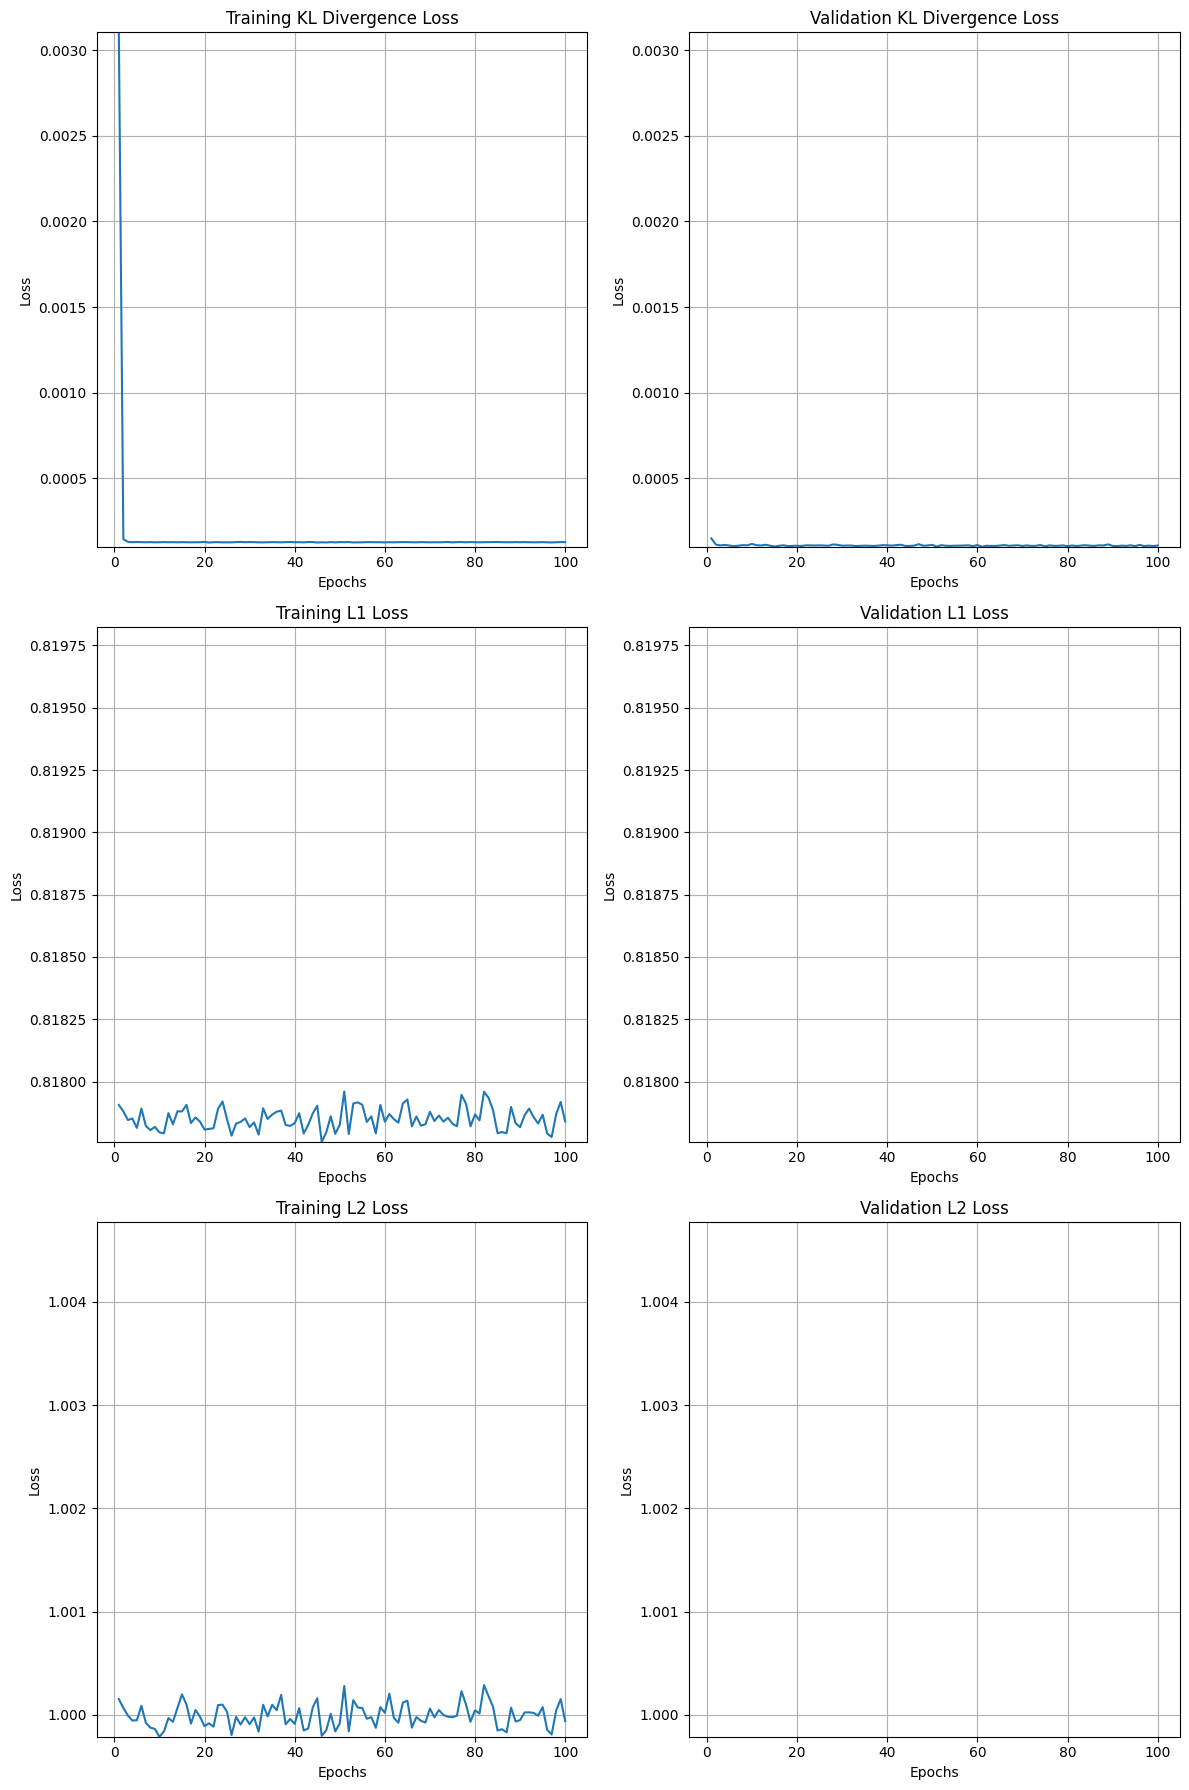

Best Validation Loss in Kelvins:
80.1397 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


z0: 0.0006
z1: 0.0005
z2: 0.0002
z3: 0.0004


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 723.86it/s]


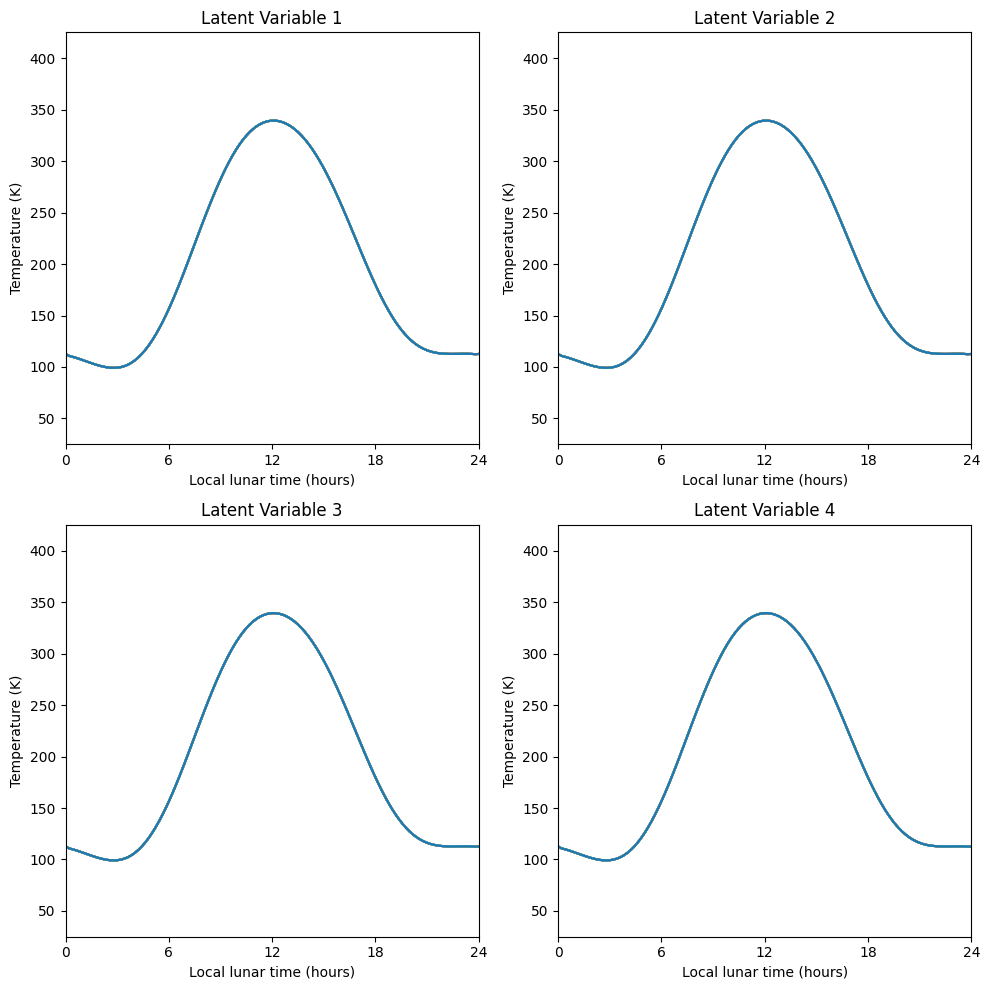

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)